# Loading Libraries

In [75]:
import torch
import torchvision
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import numpy as np
import matplotlib.pyplot as plt

# Setting-up Hyperparameters of the Experiment

In [76]:
hparams = {
    'experiment_num': 5,
    'batch_size': 512,
    'use_augmentation': True,
    'use_batch_norm': True,
    'use_dropout': True,
    'use_l2_reg': True,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'log_interval': 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# General Functions

## Visualization

In [77]:
# Function to plot samples
def plot_samples(images, N=5):
    ps = random.sample(range(0, images.shape[0]), N**2)
    f, axarr = plt.subplots(N, N, figsize=(10, 10))
    p = 0
    for i in range(N):
        for j in range(N):
            im = images[ps[p]].transpose(1, 2, 0)
            im = im / 2 + 0.5  # Unnormalize the image
            axarr[i, j].imshow(im)
            axarr[i, j].axis('off')
            p += 1
    plt.show()

## Training and Testing

In [78]:
def correct_predictions(predicted_batch, label_batch):
    pred = predicted_batch.argmax(dim=1, keepdim=True)
    return pred.eq(label_batch.view_as(pred)).sum().item()

def train_epoch(epoch, train_loader, network, optimizer, criterion, hparams):
    network.train()
    device = hparams['device']
    avg_loss = None
    avg_weight = 0.1
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if avg_loss:
            avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
        else:
            avg_loss = loss.item()
        if batch_idx % hparams['log_interval'] == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return avg_loss

def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            acc += correct_predictions(output, target)
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {acc}/{len(test_loader.dataset)} ({test_acc:.0f}%)\n')
    return test_loss, test_acc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Plotting Training and Testing Losses

In [79]:
def plot_and_save_results(tr_losses, te_losses, te_accs, experiment_num):
    # Plotting Training and Testing Losses
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(tr_losses, label='Training Loss', color='blue')
    plt.plot(te_losses, label='Testing Loss', color='red')
    plt.title(f'Training and Testing Loss Over Epochs - Experiment {experiment_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Testing Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(te_accs, label='Testing Accuracy', color='green')
    plt.title(f'Testing Accuracy Over Epochs - Experiment {experiment_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f"experiment_{experiment_num}_results.png")

    # Show the plot
    plt.show()

## Load and transform CIFAR10 dataset

In [80]:
def create_data_loaders(batch_size, use_augmentation=False):
    # Standard CIFAR10 transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Augmented CIFAR10 transforms
    train_transform_augmented = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Load augmented CIFAR10 dataset
    trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform_augmented)

    # Combine datasets
    if use_augmentation:
        trainset_augmented = ConcatDataset([trainset, trainset_augmented])

    # Choose the appropriate trainset
    trainset_to_use = trainset_augmented if use_augmentation else trainset

    # Create data loaders
    trainloader = torch.utils.data.DataLoader(trainset_to_use, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

### Let's take a look at the original and the augmented images:

#### Original Images

In [81]:
trainloader, testloader = create_data_loaders(hparams["batch_size"], False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [82]:
# Fetch the first batch of images from the trainloader
first_batch_images, _ = next(iter(trainloader))
first_image = first_batch_images[0].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

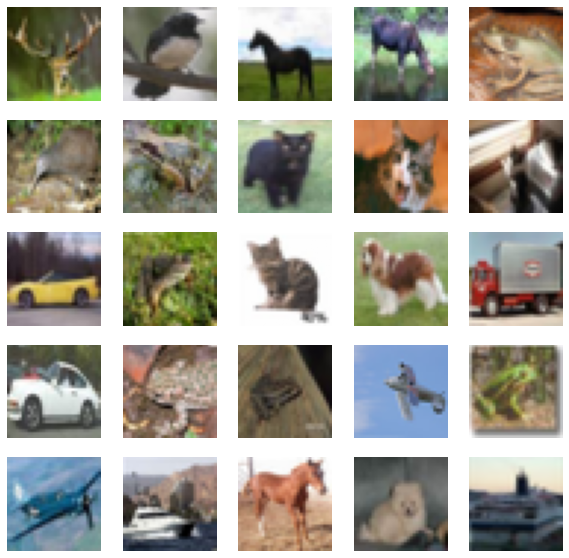

In [83]:
first_batch_images_np = first_batch_images.numpy()

# Plot samples from the first batch
plot_samples(first_batch_images_np)

In [84]:
# Print sizes of the trainloader and testloader
trainset_size = len(trainloader)
testset_size = len(testloader)

print(f"Trainset Size: {trainset_size}")
print(f"Testset Trainset Size: {testset_size}")

Trainset Size: 98
Testset Trainset Size: 20


#### Augmented Images

In [85]:
trainloader, testloader = create_data_loaders(hparams["batch_size"], True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [86]:
# Fetch the first batch of images from the trainloader
first_augmented_batch_images, _ = next(iter(trainloader))
first_augmented_image = first_augmented_batch_images[0].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

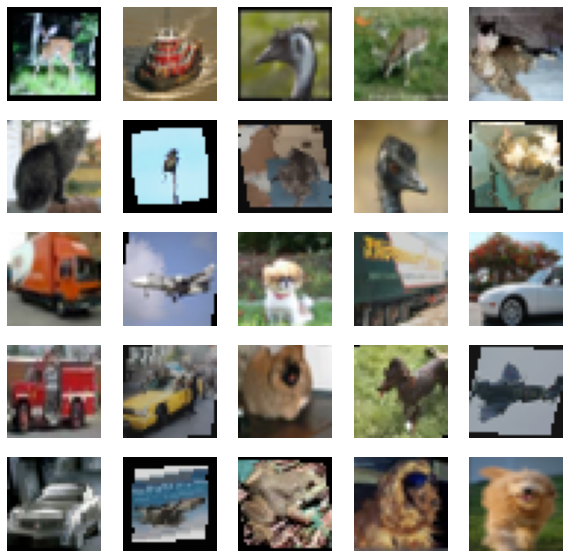

In [87]:
first_augmented_batch_images_np = first_augmented_batch_images.numpy()

# Plot samples from the first batch
plot_samples(first_augmented_batch_images_np)

In [88]:
# Print sizes of the trainloader and testloader
trainset_size = len(trainloader)
testset_size = len(testloader)

print(f"Trainloader Size: {trainset_size}")
print(f"Testloader Size: {testset_size}")

Trainloader Size: 196
Testloader Size: 20


# Define the CNN

In [89]:
# Custom CNN Architecture with Batch Normalization, and Dropout options
class CustomCNN(nn.Module):
    def __init__(self, use_batch_norm=False, use_dropout=False):
        super(CustomCNN, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        # First set of convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if self.use_batch_norm else nn.Identity()
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) if self.use_batch_norm else nn.Identity()
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) if self.use_batch_norm else nn.Identity()
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64) if self.use_batch_norm else nn.Identity()
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Third set of convolutional layers
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128) if self.use_batch_norm else nn.Identity()
        self.relu5 = nn.LeakyReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128) if self.use_batch_norm else nn.Identity()
        self.relu6 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjust the size according to your input image dimensions
        self.relu7 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First set of layers
        x = self.conv1(x)
        x = self.bn1(x) if self.use_batch_norm else x
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x) if self.use_batch_norm else x
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x) if self.use_dropout else x

        # Second set of layers
        x = self.conv3(x)
        x = self.bn3(x) if self.use_batch_norm else x
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x) if self.use_batch_norm else x
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x) if self.use_dropout else x

        # Third set of layers
        x = self.conv5(x)
        x = self.bn5(x) if self.use_batch_norm else x
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x) if self.use_batch_norm else x
        x = self.relu6(x)
        x = self.pool3(x)
        x = self.dropout3(x) if self.use_dropout else x

        # Flatten the output
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout4(x) if self.use_dropout else x
        x = self.fc2(x)

        return x

# Setting-up Functions for the Experiments

In [90]:
# Function to run an experiment
def run_experiment(experiment_num, use_augmentation=False, batch_size=hparams['batch_size'], use_batch_norm=False, use_dropout=False, use_l2_reg=False):
    # Update hyperparameters based on the experiment
    optimizer_weight_decay = 0.001 if use_l2_reg else 0

    # Choose the appropriate dataset
    trainloader, testloader = create_data_loaders(hparams["batch_size"], use_augmentation)

    # Initialize the model with the specified settings
    network = CustomCNN(use_batch_norm=use_batch_norm, use_dropout=use_dropout).to(hparams['device'])
    print(network)
    
    # Calculate the total number of trainable parameters
    total_params = count_parameters(network)
    print(f"Total trainable parameters in the model: {total_params}")
    print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

    # Define the optimizer with or without L2 regularization
    optimizer = optim.Adam(network.parameters(), lr=hparams['learning_rate'], weight_decay=optimizer_weight_decay)

    # Define the criterion
    criterion = nn.CrossEntropyLoss()

    # Training and validation loop
    tr_losses, te_losses, te_accs = [], [], []
    
    # Start the timer
    start_time = time.time()

    for epoch in range(1, hparams['num_epochs'] + 1):
        tr_losses.append(train_epoch(epoch, trainloader, network, optimizer, criterion, hparams))
        te_loss, te_acc = test_epoch(testloader, network, hparams)
        te_losses.append(te_loss)
        te_accs.append(te_acc)
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Convert elapsed time to minutes and seconds
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)

    print(f'Total Training Time: {elapsed_mins}m {elapsed_secs}s')
    
    plot_and_save_results(tr_losses, te_losses, te_accs, experiment_num)
    
    return network

# Running the Experiment

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum

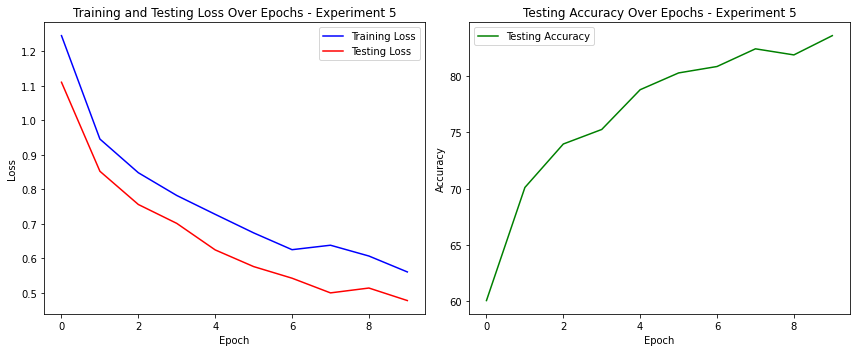

In [91]:
network = run_experiment(hparams['experiment_num'], use_augmentation=hparams['use_augmentation'], batch_size=hparams['batch_size'], use_batch_norm=hparams['use_batch_norm'], use_dropout=hparams['use_dropout'], use_l2_reg=hparams['use_l2_reg'])

In [92]:
# Save the trained model
model_path = f"experiment_{hparams['experiment_num']}_custom_cnn_model_best_task2.pth"
torch.save(network.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to experiment_5_custom_cnn_model_best_task2.pth
